# Telegraf Metrics Visualization

This notebook can be used to visualize the metrics collected by Telegraf. Currrently, only CPU and memory usage are supported.

Note that the code currently relies on the naming scheme of nodes used by Continuum for some of its functionality. It furthermore requires the driver nodes to be either the first x or the last x nodes in the list. If these assumptions are not valid, calculation of executor and driver averages will not be correct.

## Imports and Definitions

In [1]:
DIR_TELEGRAF = '../data/telegraf'
NAME_USER = 'lennart'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import math
import matplotlib.cm as cm
import numpy as np

In [8]:
def get_processed_cpu_usage(session_id, combined=True, num_drivers=1, drivers_first=True, xshift=0):

    """
    Processes CPU usage data from a CSV file, calculates relative time, and identifies driver and executor hosts.
    """

    workload, time = session_id.split('/')

    time = int(time)

    df = pd.read_csv(f"{DIR_TELEGRAF}/{workload}/{time}/cpu.csv", comment='#')
    df = df[['host', '_time', '_field', '_value']]
    df['_time'] = list(map(lambda x: x.tz_localize(None), pd.to_datetime(df['_time'])))

    hosts = df['host'].unique()

    usage_all = df[df['_field'] == 'usage_idle'].copy()
    usage_all['_value'] = 100 - usage_all['_value']
    usage_all = usage_all[['host', '_time', '_value']]
    usage_all.rename(columns={'_time': 'time', '_value': 'value'}, inplace=True)

    x = datetime.datetime.fromtimestamp(time, tz=datetime.timezone.utc).replace(tzinfo=None)

    usage_all['time_rel'] = (usage_all['time'] - x).dt.total_seconds()
    usage_all['time_rel'] = usage_all['time_rel'] + xshift

    if combined:
        driver_hosts = None
        if drivers_first:
            driver_hosts = [f'cloud{i}{NAME_USER}' for i in range(num_drivers)]
        else:
            driver_hosts = [f'cloud{i}{NAME_USER}' for i in range(len(hosts) - num_drivers, len(hosts))]

        executor_hosts = list(filter(lambda host: host not in driver_hosts, hosts))

        usage_drivers = usage_all[usage_all['host'].isin(driver_hosts)].groupby(['time_rel', 'time'], as_index=False).agg({'value': 'mean'})
        usage_drivers['host'] = '_driver-average'
        usage_executors = usage_all[usage_all['host'].isin(executor_hosts)].groupby(['time_rel', 'time'], as_index=False).agg({'value': 'mean'})
        usage_executors['host'] = '_executor-average'

        usage_all = pd.concat([usage_all, usage_drivers, usage_executors]).sort_values(['time_rel', 'host'])

    # return (usage_all, usage_drivers, usage_executors)
    return usage_all

def plot_cpu(session_id, combined=True, num_drivers=1, drivers_first=True, xshift=0):

    """
    Plot the CPU usage of all nodes in the cluster.
    """

    usage_all = get_processed_cpu_usage(session_id, num_drivers, drivers_first, xshift)
    
    hosts = usage_all['host'].unique()

    fig, axs = plt.subplots(int(math.ceil(len(hosts) / 2)), ncols=2, figsize=(10, 2 * len(hosts)))
    axs = axs.flatten()

    for i, host in enumerate(hosts):

        df_host = usage_all[usage_all['host'] == host].copy()
        df_host['time'] = pd.to_datetime(df_host['time'])
        df_host.set_index('time', inplace=True)
        rolling_avg = df_host['value'].rolling(window='30s', min_periods=1).mean()

        axs[i].plot(df_host['time_rel'], usage_all[usage_all['host'] == host]['value'], label=host)
        axs[i].plot(df_host['time_rel'], rolling_avg, label=host, linestyle='dashed')

        axs[i].set_title('Usage for ' + host)
        axs[i].set_xlabel('Time Relative to Start')
        axs[i].set_ylabel('Usage')
        axs[i].set_xlim([usage_all['time_rel'].min(), usage_all['time_rel'].max()])  # Set x limits
        axs[i].set_ylim([0, 100])  # Set y limits

    fig.tight_layout()
    plt.show()

def plot_executor_cpu(session_ids, names, num_drivers=1, drivers_first=True, xshift=0, xmin=None, xmax=None, width=None, height=None):

    """
    Plot the combined CPU utilization of all executor nodes in the cluster for a list of session IDs.
    """

    fig, ax = plt.subplots(1, 1)

    fig.set_figwidth(10)

    if width is not None:
        fig.set_figwidth(width)
    if height is not None:
        fig.set_figheight(height)
        
    dark = cm.Dark2(np.linspace(0, 1, 8))
    colors = [
        dark[3],
        dark[0],
        dark[5],
    ]

    for session_id, name, color in zip(session_ids, names, colors):

        usage_all = get_processed_cpu_usage(session_id, True, num_drivers, drivers_first, xshift)

        df = usage_all[usage_all['host'] == '_executor-average'].copy()
        df['time'] = pd.to_datetime(df['time'])
        df.set_index('time', inplace=True)

        ax.plot(df['time_rel'], df['value'], label=name, color=color)

        ax.set_xlabel('Time [s]')
        ax.set_ylabel('CPU Usage [%]')
        if xmin is not None:
            ax.set_xlim(left=xmin)
        if xmax is not None:
            ax.set_xlim(right=xmax)

        ax.set_ylim([0, 100])
        ax.legend()

    plt.show()

In [18]:
def plot_mem(session_id, num_drivers=0):

    workload, time = session_id.split('/')
    time = int(time)

    df = pd.read_csv(f'{DIR_TELEGRAF}/{workload}/{time}/mem.csv', comment='#')
    df = df[['host', '_time', '_field', '_value']]
    df['_time'] = list(map(lambda x: x.tz_localize(None), pd.to_datetime(df['_time'])))
    df.rename(columns={'_time': 'time', '_field': 'field', '_value': 'value'}, inplace=True)

    hosts = df['host'].unique()
    fields = df['field'].unique()

    df_grouped = df.pivot_table(index=['time', 'host'], columns='field', values='value').reset_index()

    x = datetime.datetime.fromtimestamp(time, tz=datetime.timezone.utc).replace(tzinfo=None)

    df_grouped['time_rel'] = (df_grouped['time'] - x).dt.total_seconds()

    for field in fields:
        df_grouped[f'{field}_rel'] = df_grouped[field] / df_grouped['total']
    
    fig, axs = plt.subplots(int(math.ceil(len(hosts) / 2)), ncols=2, figsize=(10, 2 * len(hosts)))
    axs = axs.flatten()

    for i, host in enumerate(hosts):

        df_host = df_grouped[df_grouped['host'] == host]

        axs[i].plot(df_host['time_rel'], df_host['used_rel'], label=host)
        
        axs[i].set_title('Usage for ' + host)
        axs[i].set_xlabel('Time [s]')
        axs[i].set_ylabel('Memory Usage [%]')
        axs[i].set_xlim([df_grouped['time_rel'].min(), df_grouped['time_rel'].max()])
        axs[i].set_ylim([0, 100])

    fig.tight_layout()
    plt.show()

## Usage

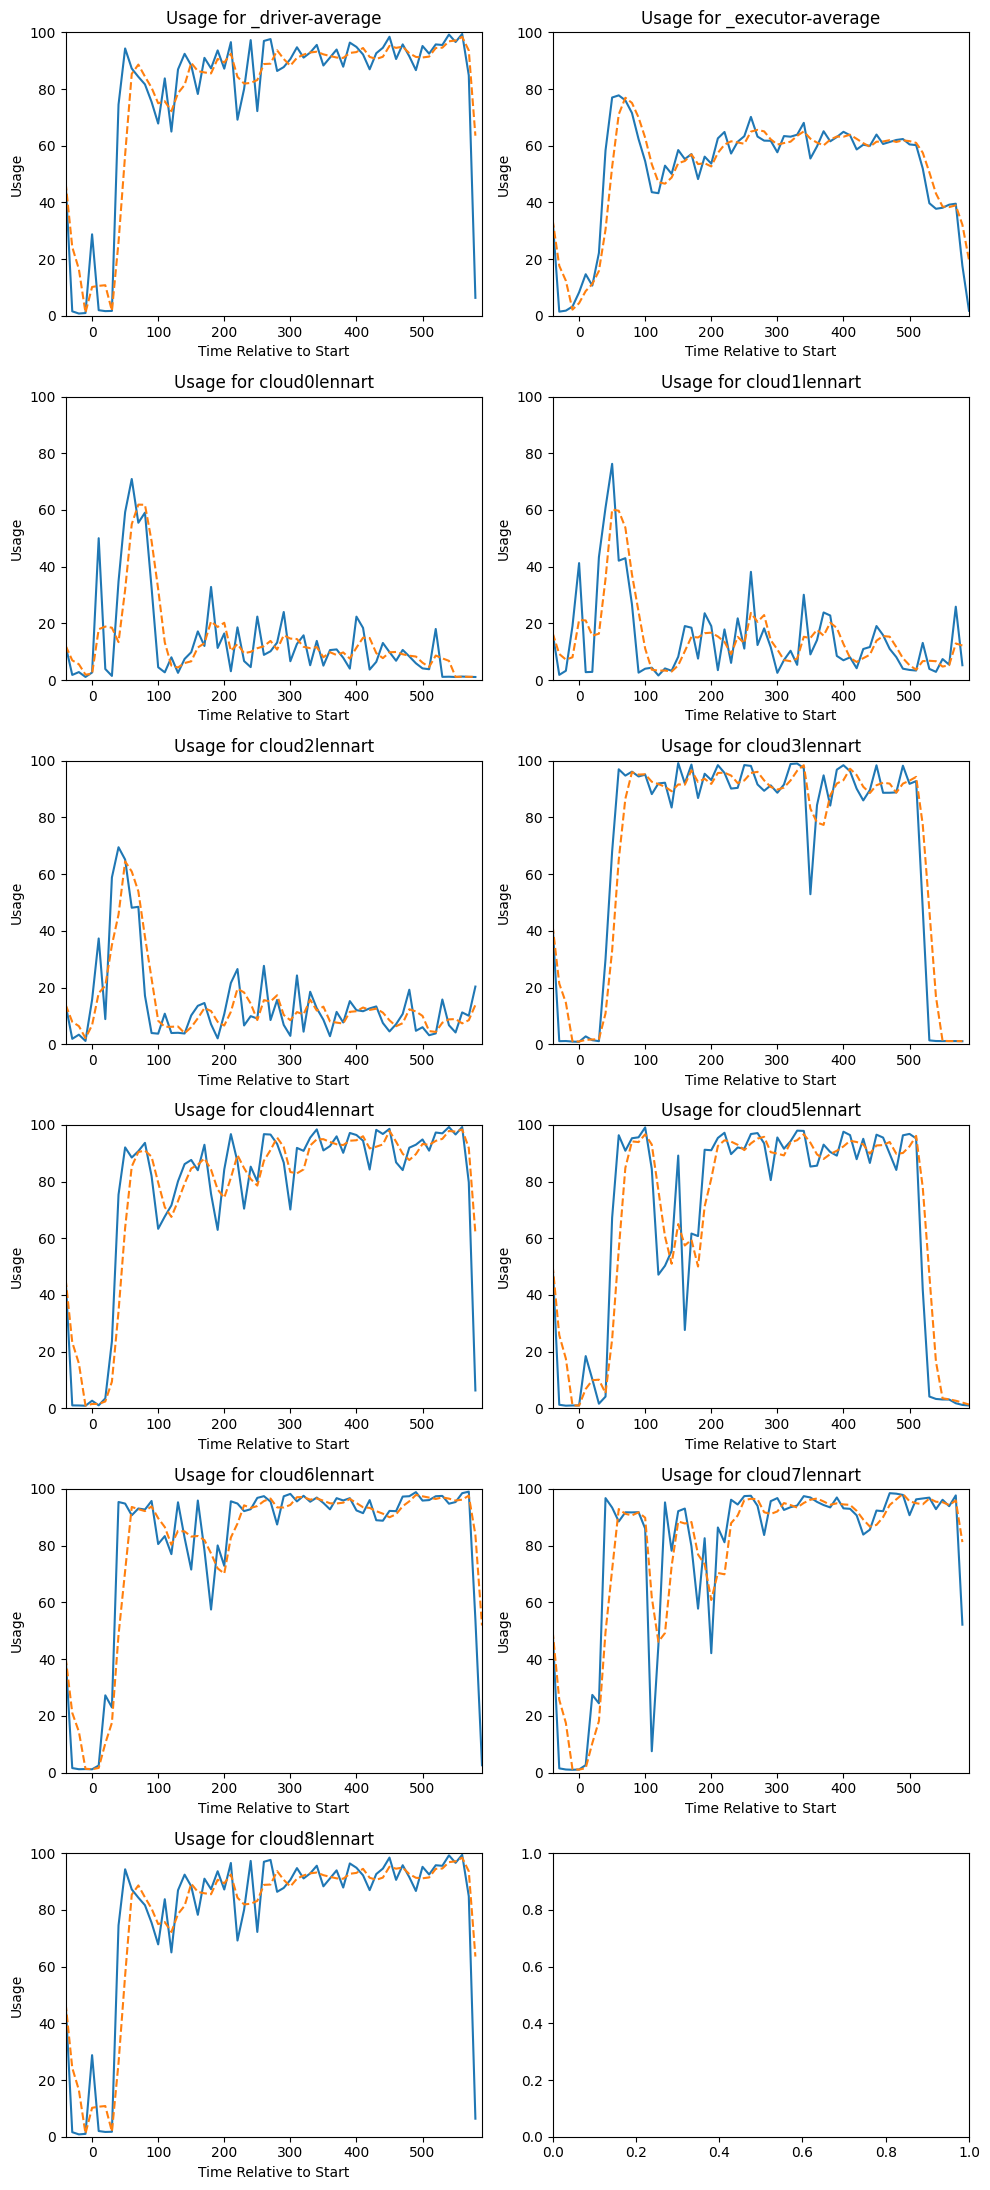

In [16]:
plot_cpu('constant-i4qd60sf350d300_3/1720520870', 3)

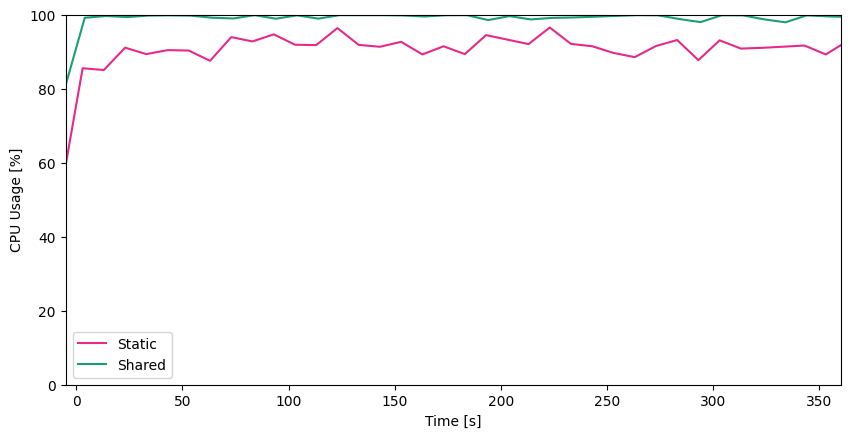

In [9]:
ids = [
    'constant-i4qd60sf375d1800_3/1718673317',
    'constant-i4qd60sf375d1800_3/1718686416',
]
names = [
    'Static',
    'Shared',
]

plot_executor_cpu(ids, names, 3, xshift=-60 * 3, xmin=-5, xmax=60 * 3 * 2)

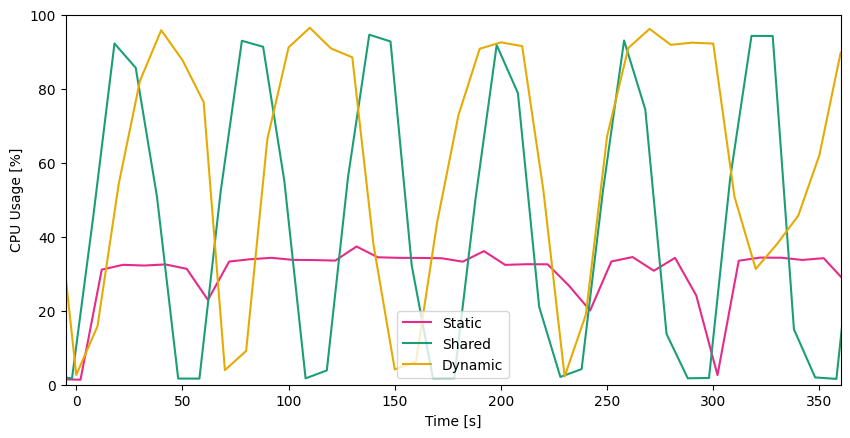

In [12]:
ids = [
    'bursty-spaced-i4bl60bb5sf350d1800_3/1718669158',
    'bursty-spaced-i4bl60bb5sf350d1800_3/1718682312',
    'bursty-spaced-i4bl60bb5sf350d1800_3/1718695550',
]
names = [
    'Static',
    'Shared',
    'Dynamic',
]

plot_executor_cpu(ids, names, 3, xshift=-60 * 3, xmin=-5, xmax=60 * 3 * 2)

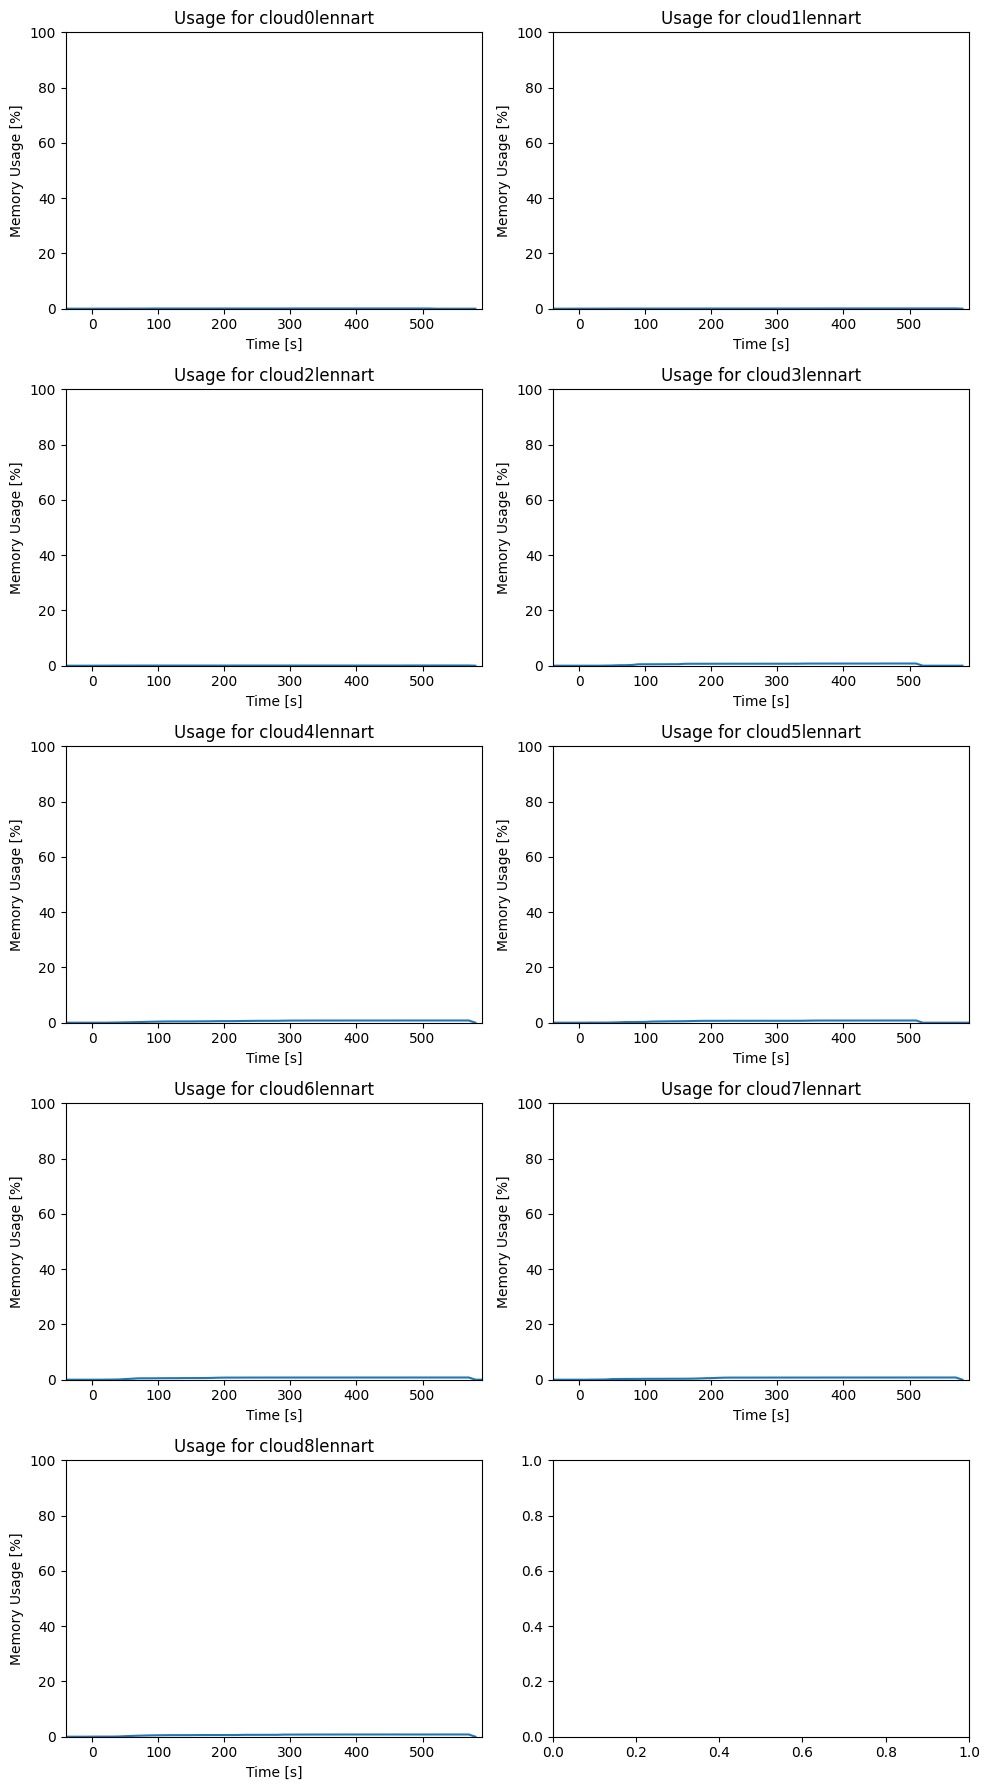

In [19]:
plot_mem('constant-i4qd60sf350d300_3/1720520870', 3)